In [29]:
%load_ext autoreload
%autoreload 2

import sys, os
import pandas as pd
import numpy as np
from tqdm import tqdm
import wandb
import matplotlib.pyplot as plt
import torch

sys.path.append(os.path.join(os.getcwd(), '../symlie'))
from misc.utils import NumpyUtils, Results, tensor_operation, numpy_operation
from model.networks.linear import LinearP

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
df = pd.read_pickle('../logs/store/results_df.pkl')
print(df.shape)
print(df.columns)
df.head()

(41, 39)
Index(['run_id', 'lr', 'net', 'bias', 'name', 'seed', 'tags', 'test', 'n_val',
       'train', 'y_low', 'device', 'n_test', 'y_high', 'log_dir', 'n_train',
       'predict', 'version', 'data_dir', 'eps_mult', 'n_splits', 'do_return',
       'noise_std', 'only_flip', 'batch_size', 'max_epochs', 'data_kwargs',
       'num_workers', 'space_length', 'generate_data', 'model_summary',
       'args_processed', 'do_return_model', 'transform_kwargs',
       'persistent_workers', 'run_name', 'test_loss', 'logger', 'grid_size'],
      dtype='object')


,run_id,lr,net,bias,name,seed,tags,test,n_val,train,...,generate_data,model_summary,args_processed,do_return_model,transform_kwargs,persistent_workers,run_name,test_loss,logger,grid_size
0,2m7eu5tn,0.0010,TrainP,False,None,5.0,[v5],True,100.0,True,...,False,False,True,False,"{'augment': 'transform_flower', 'eps_mult': [0...",True,worldly-snowflake-183,[0.0004728641652036458],NaN,NaN
1,ugylvzz6,0.0001,TrainP,False,None,5.0,[v5],True,100.0,True,...,False,False,True,False,"{'augment': 'transform_flower', 'eps_mult': [0...",True,classic-glade-184,[0.009488677605986595],NaN,NaN
2,unpw27ml,0.1000,TrainP,False,None,5.0,[v5],True,100.0,True,...,False,False,True,False,"{'augment': 'transform_flower', 'eps_mult': [0...",True,sage-river-182,[0.0035890007857233286],NaN,NaN
3,w4yjcu25,0.0100,TrainP,False,None,5.0,[v5],True,100.0,True,...,False,False,True,False,"{'augment': 'transform_flower', 'eps_mult': [0...",True,azure-grass-181,[0.0031849860679358244],NaN,NaN
4,q86f7s5e,0.0001,TrainP,False,None,5.0,[v5],True,100.0,True,...,False,False,True,False,"{'augment': 'transform_flower', 'eps_mult': [0...",True,blooming-star-180,[0.02364257164299488],NaN,NaN


## Sine1d

In [32]:
df_sine1d = df[df['tags'].astype(str).str.contains('sine1d')]
df_sine1d

,run_id,lr,net,bias,name,seed,tags,test,n_val,train,...,generate_data,model_summary,args_processed,do_return_model,transform_kwargs,persistent_workers,run_name,test_loss,logger,grid_size
0,ikydo5s3,0.1,TrainP,False,None,42.0,"['dev', 'sine1d']",True,1000.0,True,...,False,False,True,False,"{'eps_mult': [0, 0, 1, 0], 'only_flip': False}",True,zany-dawn-207,[6.171144195832312e-05],wandb,"[1, 7]"


In [45]:
df.data_kwargs

0     {'y_low': 1, 'y_high': 3, 'noise_std': 0.01, '...
1     {'y_low': 1, 'y_high': 3, 'noise_std': 0.01, '...
2     {'y_low': 1, 'y_high': 3, 'noise_std': 0.01, '...
3     {'y_low': 1, 'y_high': 3, 'noise_std': 0.01, '...
4     {'y_low': 1, 'y_high': 3, 'noise_std': 0.01, '...
5     {'y_low': 1, 'y_high': 3, 'noise_std': 0.01, '...
6     {'y_low': 1, 'y_high': 3, 'noise_std': 0.01, '...
7     {'y_low': 1, 'y_high': 3, 'noise_std': 0.01, '...
8     {'y_low': 1, 'y_high': 3, 'noise_std': 0.01, '...
9     {'y_low': 1, 'y_high': 3, 'noise_std': 0.01, '...
10    {'y_low': 1, 'y_high': 3, 'noise_std': 0.01, '...
11    {'y_low': 1, 'y_high': 3, 'noise_std': 0.01, '...
12    {'y_low': 1, 'y_high': 3, 'noise_std': 0.01, '...
13    {'y_low': 1, 'y_high': 3, 'noise_std': 0.01, '...
14    {'y_low': 1, 'y_high': 3, 'noise_std': 0.01, '...
15    {'y_low': 1, 'y_high': 3, 'noise_std': 0.01, '...
16    {'y_low': 1, 'y_high': 3, 'noise_std': 0.01, '...
17    {'y_low': 1, 'y_high': 3, 'noise_std': 0.0

{'y_low': 1, 'y_high': 3, 'grid_size': [1, 7], 'noise_std': 0.5}

In [52]:
def load_P_pred(run_id, P_dir = '../logs/store/P/'):
    P = np.load(P_dir + run_id + '.npy')
    P = torch.from_numpy(P).float()
    P = LinearP.normalize_P(P)
    return P

def find_id_for_P(args):
    df = pd.read_pickle('../logs/store/results_df.pkl')

    df_selected = df[(df.data_kwargs == args.data_kwargs) & (df.transform_kwargs == args.transform_kwargs) & (df.seed == args.seed)]


    if len(df_selected) == 0:
        raise ValueError('No results found for the given arguments')
    elif len(df_selected) > 1:
        raise ValueError('Multiple results found for the given arguments')
    else:
        pass

    run_id = df_selected.iloc[0]['run_id']

    return run_id

run_id = find_id_for_P(run)
load_P_pred(run_id)

tensor([[-0.0197, -0.0203, -0.0206,  ..., -0.0200,  0.0210,  0.0190],
        [ 0.0209, -0.0204,  0.0212,  ..., -0.0215, -0.0217, -0.0217],
        [ 0.0199, -0.0203, -0.0205,  ..., -0.0189,  0.0201,  0.0200],
        ...,
        [ 0.0204,  0.0202,  0.0208,  ..., -0.0211, -0.0209,  0.0211],
        [-0.0201, -0.0206,  0.0209,  ...,  0.0201,  0.0189, -0.0204],
        [-0.0194, -0.0204, -0.0219,  ..., -0.0201,  0.0208,  0.0195]])

In [40]:
df_sine1d.transform_kwargs

0    {'eps_mult': [0, 0, 1, 0], 'only_flip': False}
Name: transform_kwargs, dtype: object

In [39]:
df_sine1d.data_kwargs

0    {'y_low': 1, 'y_high': 3, 'grid_size': [1, 7],...
Name: data_kwargs, dtype: object

In [50]:
run.data_kwargs

{'y_low': 1, 'y_high': 3, 'grid_size': [1, 7], 'noise_std': 0.5}

In [34]:
run = df_sine1d.iloc[0]
print(run)

run_id                                                         ikydo5s3
lr                                                                  0.1
net                                                              TrainP
bias                                                              False
name                                                               None
seed                                                               42.0
tags                                                  ['dev', 'sine1d']
test                                                               True
n_val                                                            1000.0
train                                                              True
y_low                                                               1.0
device                                                              cpu
n_test                                                           1000.0
y_high                                                          

In [35]:
def load_P_pred(run_id, P_dir = '../logs/store/P/'):
    P = np.load(P_dir + run_id + '.npy')
    P = torch.from_numpy(P).float()
    P = LinearP.normalize_P(P)
    return P

In [38]:
P = load_P_pred(run.run_id)
P

tensor([[-0.0197, -0.0203, -0.0206,  ..., -0.0200,  0.0210,  0.0190],
        [ 0.0209, -0.0204,  0.0212,  ..., -0.0215, -0.0217, -0.0217],
        [ 0.0199, -0.0203, -0.0205,  ..., -0.0189,  0.0201,  0.0200],
        ...,
        [ 0.0204,  0.0202,  0.0208,  ..., -0.0211, -0.0209,  0.0211],
        [-0.0201, -0.0206,  0.0209,  ...,  0.0201,  0.0189, -0.0204],
        [-0.0194, -0.0204, -0.0219,  ..., -0.0201,  0.0208,  0.0195]])

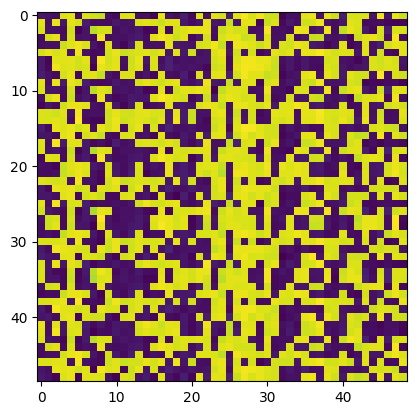

In [31]:



P_dir = '../logs/store/P'

P = np.load(os.path.join(P_dir, run.run_id + '.npy'))
P = tensor_operation(P, normalize_P)

plt.imshow(P)
plt.show()

## V5

In [52]:
df_v5 = df[df['tags'].astype(str).str.contains('v5')]
df_v5['test_loss'] = df_v5['test_loss'].astype(float)

In [60]:
run_ids = df_v5[(df_v5['lr'] == 0.001) & (df_v5['n_train'] == 10_000)]['run_id'].values

In [77]:
P_dir = '../logs/store/P/'

npu = NumpyUtils(dir = P_dir)
Ps = {run_id: npu.load(run_id) for run_id in tqdm(run_ids, leave=False)}
Ps_array = np.array(list(Ps.values()))

In [80]:
Ps_array

array([[[ 2.1465273 ,  0.5118638 , -1.4161533 , ..., -1.5310299 ,
         -0.28795776, -0.5887528 ],
        [ 0.91931355,  0.4689858 ,  0.43658555, ..., -0.41603547,
          0.2763254 , -1.7111584 ],
        [ 0.62887174, -2.0006282 ,  0.1005771 , ...,  0.6630132 ,
         -0.9503757 , -0.98250175],
        ...,
        [ 0.51184046,  1.0171272 ,  0.21487394, ..., -1.1071765 ,
          0.10788131, -0.5576322 ],
        [-0.6080637 ,  0.32362258, -0.264464  , ..., -1.6654371 ,
          1.3535056 ,  0.37845826],
        [-1.5061336 , -1.3545781 , -0.42104182, ..., -1.8227649 ,
         -0.31854895, -1.0481161 ]],

       [[-1.1060088 ,  1.2400032 ,  0.40283015, ..., -0.3369692 ,
         -1.0142059 ,  0.616472  ],
        [-0.44799823,  2.1870542 ,  1.5378758 , ..., -0.55853057,
         -2.0008779 , -1.0810724 ],
        [ 1.7416807 ,  0.4476581 ,  0.09050039, ..., -1.5524039 ,
         -0.55676043, -0.32442003],
        ...,
        [ 0.81434923,  1.4386965 , -0.9788595 , ...,  

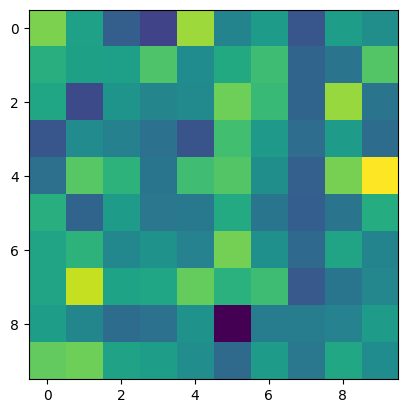

In [81]:
plt.imshow(Ps_array[0][:10, :10])

In [ ]:
    #     array = np.load(os.path.join(store_dir, store_dir_dir, f'{id}.npy'))    
    #     config[store_dir_dir] = array

In [28]:
lrs = df_v5['lr'].unique()
n_train = df_v5['n_train'].unique()
seed = df_v5['seed'].unique()

In [49]:
df_v5_agg = df_v5.groupby(['lr', 'n_train'])['test_loss']
means = df_v5_agg.mean()
stds = df_v5_agg.std()

means

lr      n_train
0.0001  1000.0     0.023878
        10000.0    0.009311
0.0010  1000.0     0.011597
        10000.0    0.000490
0.0100  1000.0     0.022928
        10000.0    0.003206
0.1000  1000.0     0.099470
        10000.0    0.003027
Name: test_loss, dtype: float64

In [43]:
df_v5[(df_v5['lr'] == 0.0001) & (df_v5['n_train'] == 1000)]['test_loss'].mean()

0.023878485336899756

In [48]:
for lr in lrs:
    for n in n_train:
        print(f'lr: {lr}, n_train: {n}')
        print(f'mean: {means[lr][n]}, std: {stds[lr][n]}')

lr: 0.001, n_train: 10000.0
mean: 0.0004903466324321926, std: 4.631198272287724e-05
lr: 0.001, n_train: 1000.0
mean: 0.011597345769405364, std: 0.0006435792996111161
lr: 0.0001, n_train: 10000.0
mean: 0.009310855902731419, std: 0.0002827898501148915
lr: 0.0001, n_train: 1000.0
mean: 0.023878485336899756, std: 0.0012433230968027036
lr: 0.1, n_train: 10000.0
mean: 0.003027223888784647, std: 0.000677990662473712
lr: 0.1, n_train: 1000.0
mean: 0.09946968853473663, std: 0.0052732493963134
lr: 0.01, n_train: 10000.0
mean: 0.0032063113059848545, std: 0.00033237877300813096
lr: 0.01, n_train: 1000.0
mean: 0.022928406298160554, std: 0.0007944920973737778
